In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)
tf.keras.backend.clear_session()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
labels_per_class = 'full' # full

### Load packages

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from IPython import display
import pandas as pd
import umap
import copy
import os, tempfile

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Load dataset

In [6]:
from tfumap.load_datasets import load_CIFAR10, mask_labels
X_train, X_test, X_valid, Y_train, Y_test, Y_valid = load_CIFAR10(flatten=False)
X_train.shape

(40000, 32, 32, 3)

In [7]:
if labels_per_class == "full":
    X_labeled = X_train
    Y_masked = Y_labeled = Y_train
else:
    X_labeled, Y_labeled, Y_masked = mask_labels(
        X_train, Y_train, labels_per_class=labels_per_class
    )

### Network architecture

In [8]:
dims = (32, 32, 3)

In [9]:
from tensorflow.keras import datasets, layers, models
from tensorflow_addons.layers import WeightNormalization

def conv_block(filts, name, kernel_size = (3, 3), padding = "same", **kwargs):
    return WeightNormalization(
        layers.Conv2D(
            filts, kernel_size, activation=None, padding=padding, **kwargs
        ),
        name="conv"+name,
    )
#CNN13
#See: 
#https://github.com/vikasverma1077/ICT/blob/master/networks/lenet.py
#https://github.com/brain-research/realistic-ssl-evaluation

In [10]:
lr_alpha = 0.1
dropout_rate = 0.5
num_classes = 10
encoder = models.Sequential()
encoder.add(tf.keras.Input(shape=dims))
### conv1a
name = '1a'
encoder.add(conv_block(name = name, filts = 128, kernel_size = (3,3), padding="same"))
encoder.add(layers.BatchNormalization(name="bn"+name))
encoder.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv1b
name = '1b'
encoder.add(conv_block(name = name, filts = 128, kernel_size = (3,3), padding="same"))
encoder.add(layers.BatchNormalization(name="bn"+name))
encoder.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv1c
name = '1c'
encoder.add(conv_block(name = name, filts = 128, kernel_size = (3,3), padding="same"))
encoder.add(layers.BatchNormalization(name="bn"+name))
encoder.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

# max pooling
encoder.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', name="mp1"))
# dropout
encoder.add(layers.Dropout(dropout_rate, name="drop1"))

### conv2a
name = '2a'
encoder.add(conv_block(name = name, filts = 256, kernel_size = (3,3), padding="same"))
encoder.add(layers.BatchNormalization(name="bn"+name))
encoder.add(layers.LeakyReLU(alpha=lr_alpha))

### conv2b
name = '2b'
encoder.add(conv_block(name = name, filts = 256, kernel_size = (3,3), padding="same"))
encoder.add(layers.BatchNormalization(name="bn"+name))
encoder.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv2c
name = '2c'
encoder.add(conv_block(name = name, filts = 256, kernel_size = (3,3), padding="same"))
encoder.add(layers.BatchNormalization(name="bn"+name))
encoder.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

# max pooling
encoder.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', name="mp2"))
# dropout
encoder.add(layers.Dropout(dropout_rate, name="drop2"))

### conv3a
name = '3a'
encoder.add(conv_block(name = name, filts = 512, kernel_size = (3,3), padding="valid"))
encoder.add(layers.BatchNormalization(name="bn"+name))
encoder.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv3b
name = '3b'
encoder.add(conv_block(name = name, filts = 256, kernel_size = (1,1), padding="valid"))
encoder.add(layers.BatchNormalization(name="bn"+name))
encoder.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv3c
name = '3c'
encoder.add(conv_block(name = name, filts = 128, kernel_size = (1,1), padding="valid"))
encoder.add(layers.BatchNormalization(name="bn"+name))
encoder.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

# max pooling
encoder.add(layers.AveragePooling2D(pool_size=(6, 6), strides=2, padding='valid'))
encoder.add(layers.Flatten())
encoder.add(layers.Dense(256, activation=None, name='z'))

In [11]:
classifier = models.Sequential()
classifier.add(tf.keras.Input(shape=(256)))
classifier.add(WeightNormalization(layers.Dense(256, activation=None)))
classifier.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelufc1'))
classifier.add(WeightNormalization(layers.Dense(256, activation=None)))
classifier.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelufc2'))
classifier.add(WeightNormalization(layers.Dense(num_classes, activation=None)), name='y_')

### Test model with just the classifier

In [51]:
from tensorflow.keras.layers import Input

In [52]:
labeled_dataset = tf.data.Dataset.from_tensor_slices((X_labeled, Y_labeled)).repeat()
labeled_dataset

<RepeatDataset shapes: ((32, 32, 3), ()), types: (tf.float32, tf.uint8)>

In [53]:
classifier_x = Input(shape=dims, name = "classifier_x")
predictions = classifier(encoder(classifier_x))
model = tf.keras.Model(
    inputs=[classifier_x],
    outputs=[predictions],
)

In [54]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=[
        tf.keras.losses.sparse_categorical_crossentropy,
    ],
    metrics=["accuracy"]

)

In [55]:
history = model.fit(
    labeled_dataset.batch(128),
    steps_per_epoch = 1000,
    epochs=5,
    validation_data=(X_valid, Y_valid),
)

Epoch 1/5
1000/1000 [==============================] - 48s 48ms/step - loss: 2.3026 - accuracy: 0.1057 - val_loss: 2.3026 - val_accuracy: 0.1051
Epoch 2/5
1000/1000 [==============================] - 47s 47ms/step - loss: 2.3026 - accuracy: 0.1058 - val_loss: 2.3026 - val_accuracy: 0.1050
Epoch 3/5
1000/1000 [==============================] - 47s 47ms/step - loss: 2.3026 - accuracy: 0.1057 - val_loss: 2.3026 - val_accuracy: 0.1051
Epoch 4/5
1000/1000 [==============================] - 47s 47ms/step - loss: 2.3026 - accuracy: 0.1057 - val_loss: 2.3026 - val_accuracy: 0.1051
Epoch 5/5
1000/1000 [==============================] - 47s 47ms/step - loss: 2.3026 - accuracy: 0.1059 - val_loss: 2.3026 - val_accuracy: 0.1051


### Test model with just UMAP

In [20]:
from tfumap.semisupervised import find_a_b
from tfumap.umap import convert_distance_to_probability

In [21]:
min_dist = 0.0
_a, _b = find_a_b(min_dist)
_a, _b 

(<tf.Tensor: shape=(), dtype=float32, numpy=1.9328084>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.790495>)

##### build iterator

In [22]:
from tfumap.semisupervised import build_fuzzy_simplicial_set
from tfumap.umap import compute_cross_entropy, get_graph_elements

In [23]:
n_neighbors = 15  # default = 15
umap_graph = build_fuzzy_simplicial_set(
    X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:]))),
    y=Y_masked,
    n_neighbors=n_neighbors,
)

In [24]:
n_epochs = 200
graph, epochs_per_sample, head, tail, weight, n_vertices = get_graph_elements(
            umap_graph, n_epochs
)
batch_size = 128
#batch_size = np.min([n_vertices, 1000])
#batch_size

In [25]:
max_sample_repeats_per_epoch = 25
# set the maximum number of times each edge should be repeated per epoch
epochs_per_sample = np.clip(
    (weight / np.max(weight)) * max_sample_repeats_per_epoch,
    1,
    max_sample_repeats_per_epoch,
).astype("int")

In [26]:
edges_to_exp, edges_from_exp = (
        np.repeat(head, epochs_per_sample.astype("int")),
       np.repeat(tail, epochs_per_sample.astype("int")),
)
shuffle_mask = np.random.permutation(range(len(edges_to_exp)))
edges_to_exp = edges_to_exp[shuffle_mask]
edges_from_exp = edges_from_exp[shuffle_mask]

In [27]:
negative_sample_rate = 5

In [28]:
def gather_X(edge_to, edge_from):
    return (tf.gather(X_train, edge_to), tf.gather(X_train, edge_from)), 0

In [29]:
edge_iter = tf.data.Dataset.from_tensor_slices((edges_to_exp, edges_from_exp))
edge_iter = edge_iter.map(gather_X)

#### Build network

In [30]:
def umap_loss(batch_size, negative_sample_rate, _a, _b, repulsion_strength = 1.0):
    def loss(placeholder_y, embed_to_from):
        # split out to/from
        embedding_to, embedding_from = tf.split(embed_to_from, num_or_size_splits=2, axis=1)

        # get negative samples
        embedding_neg_to = tf.repeat(embedding_to, negative_sample_rate, axis=0)
        repeat_neg = tf.repeat(embedding_from, negative_sample_rate, axis=0)
        embedding_neg_from = tf.gather(
            repeat_neg, tf.random.shuffle(tf.range(tf.shape(repeat_neg)[0]))
        )

        #  distances between samples (and negative samples)
        distance_embedding = tf.concat(
            [
                tf.norm(embedding_to - embedding_from, axis=1),
                tf.norm(embedding_neg_to - embedding_neg_from, axis=1),
            ],
            axis=0,
        )

        # convert probabilities to distances
        probabilities_distance = convert_distance_to_probability(
            distance_embedding, _a, _b
        )
        
        

        # set true probabilities based on negative sampling
        probabilities_graph = tf.concat(
            [tf.ones(batch_size), tf.zeros(batch_size * negative_sample_rate)],
            axis=0,
        )
                
        # compute cross entropy
        (attraction_loss, repellant_loss, ce_loss) = compute_cross_entropy(
            probabilities_graph,
            probabilities_distance,
            repulsion_strength=repulsion_strength,
        )
        return tf.reduce_mean(ce_loss)

    return loss

In [31]:
to_x = Input(shape=dims, name = "to_x")
from_x = Input(shape=dims, name = "from_x")

embedding_to = encoder(to_x)
embedding_from = encoder(from_x)
embedding_to_from = tf.concat([embedding_to, embedding_from], axis = 1)

model = tf.keras.Model(
    inputs=[to_x, from_x],
    outputs=[embedding_to_from],
)

In [32]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=umap_loss(batch_size, negative_sample_rate, _a, _b)
)

#### train

In [33]:
history = model.fit(
    edge_iter.batch(batch_size),
    steps_per_epoch = 1000,
    epochs=5,
)

Epoch 1/5
16910/29103 [================>.............] - ETA: 17:01 - loss: 0.2151

KeyboardInterrupt: 

In [34]:
z = encoder.predict(X_train)

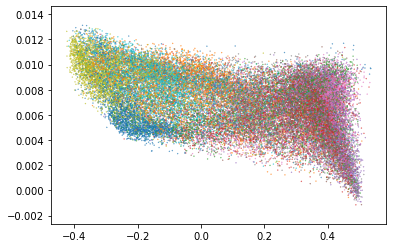

In [35]:
plt.scatter(z[:,0], z[:,1], c = Y_train, cmap = plt.cm.tab10, s = 0.1)

### Run model with both 

In [59]:
labeled_dataset = tf.data.Dataset.from_tensor_slices((X_labeled, Y_labeled)).repeat()
labeled_dataset

<RepeatDataset shapes: ((32, 32, 3), ()), types: (tf.float32, tf.uint8)>

In [60]:
edges_to_exp, edges_from_exp = (
        np.repeat(head, epochs_per_sample.astype("int")),
       np.repeat(tail, epochs_per_sample.astype("int")),
)
shuffle_mask = np.random.permutation(range(len(edges_to_exp)))
edges_to_exp = edges_to_exp[shuffle_mask]
edges_from_exp = edges_from_exp[shuffle_mask]

In [61]:
negative_sample_rate = 5

In [62]:
def gather_X(edge_to, edge_from):
    return (tf.gather(X_train, edge_to), tf.gather(X_train, edge_from)), 0

In [63]:
edge_iter = tf.data.Dataset.from_tensor_slices((edges_to_exp, edges_from_exp))
edge_iter = edge_iter.map(gather_X)

In [64]:
zipped_ds = tf.data.Dataset.zip((labeled_dataset, edge_iter))

In [65]:
def rearrange_output(label_iter_out, edge_iter_out):
    X_lab, Y_lab = label_iter_out
    (X_to, X_from), edge_prob = edge_iter_out
    return (X_lab, X_to, X_from), {"classifier":Y_lab, "umap": edge_prob}

In [66]:
zipped_ds = tf.data.Dataset.zip((labeled_dataset, edge_iter))
zipped_ds = zipped_ds.map(rearrange_output)
zipped_ds = zipped_ds.shuffle(5000)
zipped_ds = zipped_ds.batch(128)

In [67]:
(X_lab, X_to, X_from), test  = next(iter(zipped_ds))
X_lab.shape, X_to.shape, X_from.shape

(TensorShape([128, 32, 32, 3]),
 TensorShape([128, 32, 32, 3]),
 TensorShape([128, 32, 32, 3]))

In [68]:
to_x = Input(shape=dims, name = "to_x")
from_x = Input(shape=dims, name = "from_x")
classifier_x = Input(shape=dims, name = "classifier_x")

embedding_to = encoder(to_x)
embedding_from = encoder(from_x)
embedding_to_from = tf.concat([embedding_to, embedding_from], axis = 1, name = 'umap')

predictions = tf.identity(classifier(encoder(classifier_x)), 'classifier')

model = tf.keras.Model(
    inputs=[classifier_x, to_x, from_x],
    outputs={"classifier": predictions, "umap":embedding_to_from},
)

In [69]:
embedding_to_from.name

'umap_1:0'

In [70]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss={
        "classifier": tf.keras.losses.sparse_categorical_crossentropy,
        "umap": umap_loss(batch_size, negative_sample_rate, _a, _b),
    },
    metrics={"classifier":"accuracy"}

)

In [72]:
history = model.fit(
    zipped_ds,
    epochs=5,
    steps_per_epoch = 10,
    validation_data={"classifier":(X_valid, Y_valid)},
    #callbacks = [early_stopping]
)

Epoch 1/5
100/100 [==============================] - ETA: 0s - loss: 4.0229 - tf_op_layer_classifier_1_loss: 3.8166 - tf_op_layer_umap_1_loss: 0.2063 - tf_op_layer_classifier_1_accuracy: 0.1474

W0810 13:01:20.914008 140166380767040 functional.py:587] Model was constructed with shape (None, 32, 32, 3) for input Tensor("to_x_2:0", shape=(None, 32, 32, 3), dtype=float32), but it was called on an input with incompatible shape (None, 1).


ValueError: in user code:

    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1224 test_function  *
        return step_function(self, iterator)
    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1215 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1208 run_step  **
        outputs = model.test_step(data)
    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1174 test_step
        y_pred = self(x, training=False)
    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/keras/engine/functional.py:386 call
        inputs, training=training, mask=mask)
    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/keras/engine/functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:976 __call__
        self.name)
    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/keras/engine/input_spec.py:180 assert_input_compatibility
        str(x.shape.as_list()))

    ValueError: Input 0 of layer sequential is incompatible with the layer: expected ndim=4, found ndim=2. Full shape received: [None, 1]


In [131]:
X_valid.shape

(10000, 32, 32, 3)

In [199]:
from sklearn.datasets import make_moons, make_blobs

X, X_lab = make_moons(1000, noise = .1)
Y, Y_lab = make_blobs(1000)

valid_X, valid_X_lab = make_moons(1000, noise = .1)

X_in = Input(shape=(2))
Y_in = Input(shape=(2))
shared_layer = tf.keras.layers.Dense(256, activation = 'relu')

X_out = tf.identity(tf.keras.layers.Dense(2, activation=None)(shared_layer(X_in)), name="loss_X")
Y_out = tf.identity(tf.keras.layers.Dense(3, activation=None)(shared_layer(Y_in)), name="loss_Y")

model = tf.keras.Model(
    inputs=[X_in, Y_in],
    outputs={"loss_X": X_out, "loss_Y":Y_out},
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss={
        "loss_X": tf.keras.losses.sparse_categorical_crossentropy,
        "loss_Y": tf.keras.losses.sparse_categorical_crossentropy,
    },
)

dataset = tf.data.Dataset.from_tensor_slices(((X,Y), {"loss_X":X_lab, "loss_Y":Y_lab})).batch(100)

history = model.fit(
    dataset,
    epochs=10,
    #validation_data={"loss_X": (X_valid, valid_X_lab)}, ### how do I do this??
)

Epoch 1/10
10/10 [==============================] - 0s 3ms/step - loss: 3.1851 - tf_op_layer_loss_X_3_loss: 1.6752 - tf_op_layer_loss_Y_3_loss: 1.5099
Epoch 2/10
10/10 [==============================] - 0s 3ms/step - loss: 0.8787 - tf_op_layer_loss_X_3_loss: 0.4522 - tf_op_layer_loss_Y_3_loss: 0.4265
Epoch 3/10
10/10 [==============================] - 0s 3ms/step - loss: 0.6953 - tf_op_layer_loss_X_3_loss: 0.4179 - tf_op_layer_loss_Y_3_loss: 0.2774
Epoch 4/10
10/10 [==============================] - 0s 3ms/step - loss: 0.6891 - tf_op_layer_loss_X_3_loss: 0.4232 - tf_op_layer_loss_Y_3_loss: 0.2659
Epoch 5/10
10/10 [==============================] - 0s 3ms/step - loss: 0.6778 - tf_op_layer_loss_X_3_loss: 0.4286 - tf_op_layer_loss_Y_3_loss: 0.2492
Epoch 6/10
10/10 [==============================] - 0s 3ms/step - loss: 0.6557 - tf_op_layer_loss_X_3_loss: 0.4242 - tf_op_layer_loss_Y_3_loss: 0.2315
Epoch 7/10
10/10 [==============================] - 0s 3ms/step - loss: 0.6552 - tf_op_layer_l

In [216]:
from sklearn.datasets import make_moons, make_blobs

X, X_lab = make_moons(1000, noise=0.1)
Y, Y_lab = make_blobs(1000)

valid_X, valid_X_lab = make_moons(1000, noise=0.1)
valid_Y, valid_Y_lab = make_blobs(1000)

X_in = Input(shape=(2))
Y_in = Input(shape=(2))
shared_layer = tf.keras.layers.Dense(256, activation="relu")

X_out = tf.identity(
    tf.keras.layers.Dense(2, activation=None)(shared_layer(X_in)), name="loss_X"
)
Y_out = tf.identity(
    tf.keras.layers.Dense(3, activation=None)(shared_layer(Y_in)), name="loss_Y"
)

Y_out = tf.keras.layers.Lambda(lambda x: x, name='Y')(Y_out)
X_out = tf.keras.layers.Lambda(lambda x: x, name='X')(X_out)

model = tf.keras.Model(inputs=[X_in, Y_in], outputs={"loss_X": X_out, "loss_Y": Y_out},)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss={
        "loss_X": tf.keras.losses.sparse_categorical_crossentropy,
        "loss_Y": tf.keras.losses.sparse_categorical_crossentropy,
    },
)

dataset = tf.data.Dataset.from_tensor_slices(
    ((X, Y), {"loss_X": X_lab, "loss_Y": Y_lab})
).batch(100)

history = model.fit(
    dataset,
    epochs=10,
    # validation_data=((valid_X, valid_Y),(valid_X_lab, valid_Y_lab)),  # this works
    #validation_data=(
    #    (valid_X, valid_Y),
    #    {"loss_X": valid_X_lab, "loss_Y": valid_Y_lab},
    #),  ### how do I do this??
    validation_data=(
        (valid_X, tf.zeros_like(valid_Y)),
        {"loss_X": valid_X_lab},
    ),  ### how do I do this??
)

Epoch 1/10
10/10 [==============================] - 0s 17ms/step - loss: 2.6288 - X_loss: 1.5300 - Y_loss: 1.0988 - val_loss: 0.6931 - val_X_loss: 0.6931 - val_Y_loss: 0.0000e+00
Epoch 2/10
10/10 [==============================] - 0s 9ms/step - loss: 1.1040 - X_loss: 0.6931 - Y_loss: 0.4109 - val_loss: 0.6931 - val_X_loss: 0.6931 - val_Y_loss: 0.0000e+00
Epoch 3/10
10/10 [==============================] - 0s 8ms/step - loss: 1.0645 - X_loss: 0.6931 - Y_loss: 0.3713 - val_loss: 0.6931 - val_X_loss: 0.6931 - val_Y_loss: 0.0000e+00
Epoch 4/10
10/10 [==============================] - 0s 8ms/step - loss: 1.0593 - X_loss: 0.6931 - Y_loss: 0.3662 - val_loss: 0.6931 - val_X_loss: 0.6931 - val_Y_loss: 0.0000e+00
Epoch 5/10
10/10 [==============================] - 0s 8ms/step - loss: 1.0590 - X_loss: 0.6931 - Y_loss: 0.3658 - val_loss: 0.6931 - val_X_loss: 0.6931 - val_Y_loss: 0.0000e+00
Epoch 6/10
10/10 [==============================] - 0s 8ms/step - loss: 1.0590 - X_loss: 0.6931 - Y_loss: 0.3

In [217]:
history.history

{'loss': [2.628807783126831,
  1.104039192199707,
  1.064473032951355,
  1.0593043565750122,
  1.0589854717254639,
  1.0589854717254639,
  1.0589854717254639,
  1.0589854717254639,
  1.0589854717254639,
  1.0589854717254639],
 'X_loss': [1.5300360918045044,
  0.6931471824645996,
  0.6931471824645996,
  0.6931471824645996,
  0.6931471824645996,
  0.6931471824645996,
  0.6931471824645996,
  0.6931471824645996,
  0.6931471824645996,
  0.6931471824645996],
 'Y_loss': [1.0987718105316162,
  0.4108920693397522,
  0.37132591009140015,
  0.3661572337150574,
  0.36583825945854187,
  0.36583825945854187,
  0.36583825945854187,
  0.36583825945854187,
  0.36583825945854187,
  0.36583825945854187],
 'val_loss': [0.6931474804878235,
  0.6931474804878235,
  0.6931474804878235,
  0.6931474804878235,
  0.6931474804878235,
  0.6931474804878235,
  0.6931474804878235,
  0.6931474804878235,
  0.6931474804878235,
  0.6931474804878235],
 'val_X_loss': [0.6931474804878235,
  0.6931474804878235,
  0.6931474804

In [ ]:
finished

In [140]:
dataset = tf.data.Dataset.from_tensor_slices(((X, Y), (X_lab, Y_lab))).batch(100)


In [142]:
history = model.fit(
    dataset,
    epochs=10,
    #validation_data={"loss_X": (X_valid, X_valid_lab)}, ### how do I do this??
)

Epoch 1/10


TypeError: in user code:

    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:759 train_step
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/keras/engine/compile_utils.py:388 update_state
        self.build(y_pred, y_true)
    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/keras/engine/compile_utils.py:319 build
        self._metrics, y_true, y_pred)
    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/util/nest.py:1139 map_structure_up_to
        **kwargs)
    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/util/nest.py:1221 map_structure_with_tuple_paths_up_to
        expand_composites=expand_composites)
    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/util/nest.py:825 assert_shallow_structure
        shallow_type=type(shallow_tree)))

    TypeError: The two structures don't have the same sequence type. Input structure has type <class 'tuple'>, while shallow structure has type <class 'dict'>.


In [141]:
history = model.fit(
    X,
    X_lab,
    epochs=10,
    #validation_data={"loss_X": (X_valid, X_valid_lab)}, ### how do I do this??
)

Epoch 1/10


AssertionError: in user code:

    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:747 train_step
        y_pred = self(x, training=True)
    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/keras/engine/functional.py:386 call
        inputs, training=training, mask=mask)
    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/keras/engine/functional.py:517 _run_internal_graph
        assert x_id in tensor_dict, 'Could not compute output ' + str(x)

    AssertionError: Could not compute output Tensor("dense_23/BiasAdd:0", shape=(None, 3), dtype=float32)


In [ ]:


X_in = Input(shape=X_DIMS)
Y_in = Input(shape=Y_DIMS)

X_out = my_model(X_in)
Y_out = my_model(Y_in)

model = tf.keras.Model(
    inputs=[X_in, Y_in],
    outputs={"loss_X": X_out, "loss_Y":Y_out},
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss={
        "loss_X": custom_loss_function_X,
        "loss_Y": custom_loss_function_Y,
    },
)

dataset1 = tf.data.Dataset.from_tensor_slices(((X, Y), (X_lab, Y_lab)))

history = model.fit(
    zipped_ds,
    epochs=10,
    validation_data={"loss_X": (X_valid, X_valid_lab)}, ### how do I do this??
)

In [50]:
history.history

{'loss': [2.8101305961608887,
  2.8421857357025146,
  2.8564302921295166,
  2.6592190265655518,
  2.532243013381958],
 'tf_op_layer_classifier_loss': [2.5873708724975586,
  2.6127495765686035,
  2.604707956314087,
  2.406277656555176,
  2.3025827407836914],
 'tf_op_layer_umap_loss': [0.22275994718074799,
  0.22943590581417084,
  0.25172287225723267,
  0.252939909696579,
  0.22965747117996216],
 'tf_op_layer_classifier_accuracy': [0.1899999976158142,
  0.17921875417232513,
  0.15156249701976776,
  0.11882812529802322,
  0.10203125327825546]}

In [ ]:
deleteme

In [ ]:
min_dist = 0.0

In [ ]:
from tfumap.semisupervised import find_a_b

In [ ]:
from tfumap.umap import convert_distance_to_probability

In [ ]:
_a, _b = find_a_b(min_dist)

In [ ]:
from tensorflow.keras.layers import Input

In [ ]:
classifier_x = Input(shape=dims, name = "classifier_x")
to_x = Input(shape=dims, name = "to_x")
from_x = Input(shape=dims, name = "from_x")

In [ ]:
predictions = classifier(encoder(classifier_x))

In [ ]:
embedding_to = encoder(to_x)
embedding_from = encoder(from_x)

In [ ]:
def umap_loss(negative_sample_rate, _a, _b):
    def loss(embed_to_from, placeholder_y):
        # split out to/from
        tf.print(embed_to_from)
        print(embed_to_from)
        embedding_to, embedding_from = tf.split(embed_to_from, num_or_size_splits=2, axis=1)

        # get negative samples
        embedding_neg_to = tf.repeat(embedding_to, negative_sample_rate, axis=0)
        repeat_neg = tf.repeat(embedding_from, negative_sample_rate, axis=0)
        embedding_neg_from = tf.gather(
            repeat_neg, tf.random.shuffle(tf.range(tf.shape(repeat_neg)[0]))
        )

        #  distances between samples (and negative samples)
        distance_embedding = tf.concat(
            [
                tf.norm(embedding_to - embedding_from, axis=1),
                tf.norm(embedding_neg_to - embedding_neg_from, axis=1),
            ],
            axis=0,
        )

        # convert probabilities to distances
        probabilities_distance = convert_distance_to_probability(
            distance_embedding, _a, _b
        )

        # set true probabilities based on negative sampling
        probabilities_graph = tf.concat(
            [tf.ones(embedding_to.shape[0]), tf.zeros(embedding_neg_to.shape[0])],
            axis=0,
        )

        # compute cross entropy

        (attraction_loss, repellant_loss, ce_loss) = compute_cross_entropy(
            probabilities_graph,
            probabilities_distance,
            repulsion_strength=self.repulsion_strength,
        )
        return tf.reduce_mean(ce_loss)

    return loss

In [ ]:
def umap_loss_ph(embed_to_from, y_ph):
    return tf.reduce_mean(embed_to_from)

In [ ]:
embedding_to

In [ ]:
embedding_from

In [ ]:
embedding_to_from = tf.concat([embedding_to, embedding_from], axis = 1)

In [ ]:
embedding_to_from

In [ ]:
embedding_to = classifier(encoder(classifier_x))

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='mse'
)

In [ ]:
history = model.fit(
    edge_iter.batch(32),
    epochs=500,
    #validation_data=(X_valid, Y_valid),
    #callbacks = [early_stopping]
)

In [ ]:
#model.compile(
#    optimizer=tf.keras.optimizers.Adam(1e-3),
#    loss=umap_loss(negative_sample_rate,  _a, _b)
#)

In [ ]:
X_to, X_from, edge_prob_ph  = next(iter(edge_iter.batch(32)))
X_to.shape, X_from.shape

In [ ]:
model.predict((X_to, X_from))

In [ ]:
model = tf.keras.Model(
    inputs=[classifier_x, from_x, to_x],
    outputs=[embedding_to_from, predictions],
)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=[
        umap_loss(negative_sample_rate,  _a, _b),
        tf.keras.losses.sparse_categorical_crossentropy,
    ]
)

In [ ]:
history = model.fit(
    zipped_ds,
    epochs=500,
    #validation_data=(X_valid, Y_valid),
    #callbacks = [early_stopping]
)

In [ ]:
(X_lab, X_to, X_from), (Y_lab, edge_prob)  = next(iter(zipped_ds))
X_lab.shape, X_to.shape, X_from.shape

In [ ]:
Y_pred, edge_prob_predict = model.predict((X_lab, X_to, X_from))